In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.color import rgb2lab, lab2rgb
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, LeaveOneGroupOut, GroupKFold

In [2]:
file = "rgb_comparison_new.csv"
df = pd.read_csv(file)
df

,hand,red_hand,green_hand,blue_hand,nail,red_nail,green_nail,blue_nail,red_sensor,green_sensor,blue_sensor
0,5920,220,187,163,8238,214,176,167,67,60,53
1,6624,217,182,161,8882,206,178,164,65,57,51
2,5921,220,185,163,9565,204,173,160,65,57,51
3,12028,192,153,130,6747,218,183,167,48,45,38
4,14257,182,145,122,8174,212,177,164,46,44,38
5,14257,182,145,122,8763,210,171,155,48,46,39
6,9296,206,165,144,9710,207,175,171,75,70,57
7,8615,209,168,146,6104,221,188,172,74,70,57
8,9326,207,164,145,4825,229,192,181,74,65,54
9,5816,220,183,155,6873,220,183,174,71,65,56


In [3]:
rgbs = np.zeros((len(df), 3, 3))
for index, row in df.iterrows():
    hand_rgb = [row["red_hand"], row["green_hand"], row["blue_hand"]]
    nail_rgb = [row["red_nail"], row["green_nail"], row["blue_nail"]]
    sensor_rgb = [row["red_sensor"], row["green_sensor"], row["blue_sensor"]]
    rgbs[index] = np.array([hand_rgb, nail_rgb, sensor_rgb])

In [4]:
def rgb_to_ita(red, green, blue):
    img = np.empty((3), dtype=np.float32)
    img[0] = red/255
    img[1] = green/255
    img[2] = blue/255
    lab = rgb2lab(img)
    L = lab[0]
    b = lab[2]
    return np.arctan((L-50)/b) * (180/np.pi)

In [5]:
hand_true_ita = np.zeros(len(df))
for i in range(len(df)):
    hand_true_ita[i] = rgb_to_ita(rgbs[i, 0, 0], rgbs[i, 0, 1], rgbs[i, 0, 2])

nail_true_ita = np.zeros(len(df))
for i in range(len(df)):
    nail_true_ita[i] = rgb_to_ita(rgbs[i, 1, 0], rgbs[i, 1, 1], rgbs[i, 1, 2])

In [6]:
def bland_altman_plot(big_data1, big_data2, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ["red", "green", "blue"]
    for i in range(3):
        data1 = big_data1[:,i][big_data1[:,i] != 0]
        data2 = big_data2[:,i][big_data2[:,i] != 0]
        mean  = np.mean([data1, data2], axis=0)
        diff = data1 - data2                 # Difference between data1 and data2
        md = np.mean(diff)                   # Mean of the difference
        sd = np.std(diff, axis=0)            # Standard deviation of the difference
        axes[i].scatter(mean, diff, color=colors[i])
        axes[i].axhline(md, color='gray', linestyle='--')
        axes[i].axhline(md + 1.96*sd, color='gray', linestyle='--')
        axes[i].axhline(md - 1.96*sd, color='gray', linestyle='--')
        #axes[i].title.set_text(f'The value of {colors[i]} values')
        axes[i].set(xlabel=f"Mean of the test and pred for {colors[i]} values", ylabel=f"Difference of the test and pred for {colors[i]} values")
    plt.suptitle(title)
    plt.show()         

In [7]:
def ita_compare_plot(true, pred, title=''):
    plt.scatter(range(len(true)), true, label="True ITA", s=50)
    plt.scatter(range(len(true)), pred, label="Predicted ITA", s=50)
    if ((np.min(true)) < 28 or np.min(pred) < 28) :
        plt.axhline(y = 10, color = 'gray', linestyle = '--')
    if ((np.min(true)) < 41 or np.min(pred) < 41) :
        plt.axhline(y = 28, color = 'gray', linestyle = '--')
    plt.axhline(y = 41, color = 'gray', linestyle = '--')
    plt.axhline(y = 55, color = 'gray', linestyle = '--')
    plt.xlabel("Subject Number")
    plt.ylabel("Individual Typology Angle")
    plt.title(title)
    plt.legend(loc='lower left')
    plt.savefig(f"{title}.png")

### LOOCV with Hand Data

In [8]:
crossX = rgbs[:, 2, :]
crossY = rgbs[:, 0, :]
groups = np.repeat(np.array([list(range(1, 12))]), 3)
print("By using the hand data with cross validation")
print("The shape of crossX:", crossX.shape)
print("The shape of crossY:", crossY.shape)

By using the hand data with cross validation
The shape of crossX: (33, 3)
The shape of crossY: (33, 3)


In [9]:
logo = LeaveOneGroupOut()
mse_arr = np.zeros((11, 3))
rmse_arr = np.zeros((11, 3))
std_arr = np.zeros((11, 3))
predY_arr = np.zeros((33, 3))
testY_arr = np.zeros((11*3, 3))

i = 0
for train_index, test_index in logo.split(crossX, crossY, groups):
    #print("TEST:", test_index)
    #test_indices.append(test_index)
    trainX, testX = crossX[train_index], crossX[test_index]
    trainY, testY = crossY[train_index], crossY[test_index]
    linreg = LinearRegression()
    linreg.fit(trainX, trainY)
    predY = linreg.predict(testX)
    predY_arr[i*3:i*3+3] = predY
    testY_arr[i*3:i*3+3] = testY
    i += 1

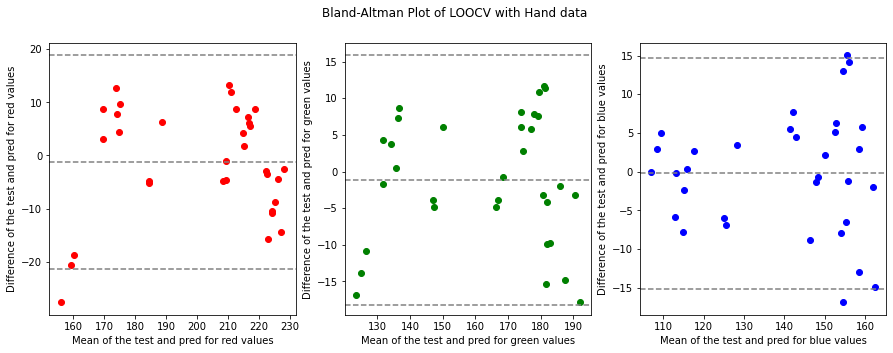

In [10]:
bland_altman_plot(testY_arr, predY_arr, "Bland-Altman Plot of LOOCV with Hand data")

In [11]:
hand_pred_ITA = np.zeros(11*3)
for i in range(len(predY_arr)):
    hand_pred_ITA[i] = rgb_to_ita([i][0], predY_arr[i][1], predY_arr[i][2])

In [12]:
#ita_compare_plot(hand_true_ita, hand_pred_ITA, "Predicted Vs. True ITAs for Hand Data by Using Predicted RGB")

In [13]:
np.average(hand_true_ita.reshape(-1, 3), axis=1)

array([59.84942271, 38.6142686 , 52.08944604, 53.70039752, 13.4130628 ,
       28.19156948, 58.54400205, 30.1823612 , 49.3043158 , 51.43428549,
       54.64921567])

In [14]:
np.average(hand_pred_ITA.reshape(-1, 3), axis=1)

array([ 78.2041342 ,  72.64213994,  66.90080547,  79.68591402,
       -11.05311958, -45.46312204,  75.90751691, -23.3319059 ,
        84.96908297,  83.16118383,  79.64699483])

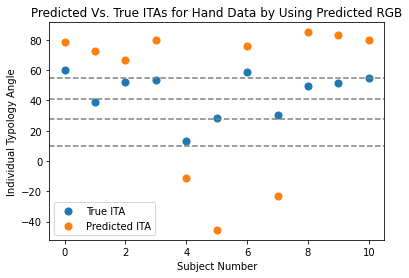

In [15]:
ita_compare_plot(np.average(hand_true_ita.reshape(-1, 3), axis=1), np.average(hand_pred_ITA.reshape(-1, 3), axis=1), "Predicted Vs. True ITAs for Hand Data by Using Predicted RGB")

### LOOCV with nail data

In [16]:
crossX = rgbs[:, 2, :]
crossY = rgbs[:, 1, :]
groups = np.repeat(np.array([list(range(1, 12))]), 3)
print("By using the nail data with cross validation")
print("The shape of crossX:", crossX.shape)
print("The shape of crossY:", crossY.shape)

By using the nail data with cross validation
The shape of crossX: (33, 3)
The shape of crossY: (33, 3)


In [17]:
logo = LeaveOneGroupOut()
mse_arr = np.zeros((11, 3))
rmse_arr = np.zeros((11, 3))
std_arr = np.zeros((11, 3))
predY_arr = np.zeros((33, 3))
testY_arr = np.zeros((11*3, 3))

i = 0
for train_index, test_index in logo.split(crossX, crossY, groups):
    #print("TEST:", test_index)
    #test_indices.append(test_index)
    trainX, testX = crossX[train_index], crossX[test_index]
    trainY, testY = crossY[train_index], crossY[test_index]
    linreg = LinearRegression()
    linreg.fit(trainX, trainY)
    predY = linreg.predict(testX)
    predY_arr[i*3:i*3+3] = predY
    testY_arr[i*3:i*3+3] = testY
    i += 1

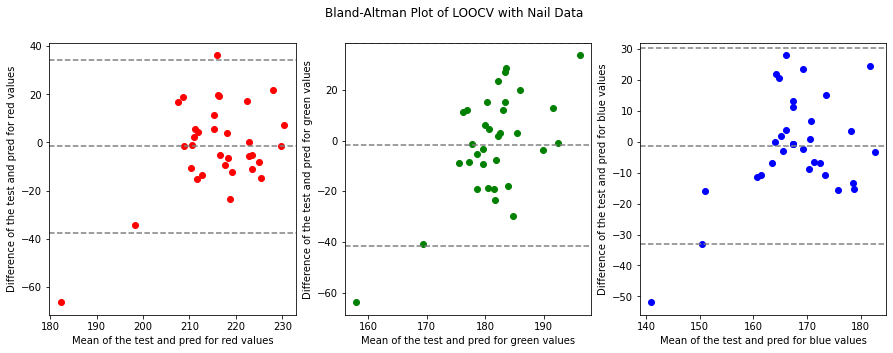

In [18]:
bland_altman_plot(testY_arr, predY_arr, "Bland-Altman Plot of LOOCV with Nail Data")

In [19]:
nail_pred_ITA = np.zeros(11*3)
for i in range(len(testY_arr)):
    nail_pred_ITA[i] = rgb_to_ita(predY_arr[i][0], predY_arr[i][1], predY_arr[i][2])

In [20]:
#ita_compare_plot(nail_true_ita, nail_pred_ITA, "Predicted Vs. True ITAs for Nail Data by Using Predicted RGB")

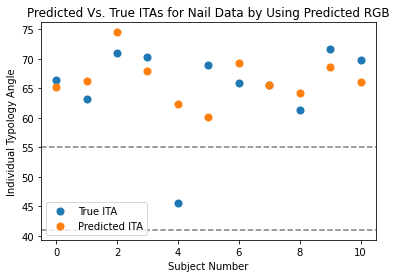

In [21]:
ita_compare_plot(np.average(nail_true_ita.reshape(-1, 3), axis=1), np.average(nail_pred_ITA.reshape(-1, 3), axis=1), "Predicted Vs. True ITAs for Nail Data by Using Predicted RGB")